#### Package Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import great_circle
import folium
from folium.plugins import HeatMap
from scipy.stats import gaussian_kde
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker

#### Load the Data

In [2]:
houses = pd.read_csv('data\king_county_house_data.csv')
houses.info()
houses

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21145 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17749 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  float64
 18  sqft_l

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,house_id,id.1
0,7129300520,3.0,1.00,1180.0,5650.0,1.0,NaN,0.0,3,7,...,0.0,98178,47.5112,-122.257,1340.0,5650.0,2014-10-13,221900.0,7129300520,1
1,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3,7,...,19910.0,98125,47.7210,-122.319,1690.0,7639.0,2014-12-09,538000.0,6414100192,2
2,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3,6,...,NaN,98028,47.7379,-122.233,2720.0,8062.0,2015-02-25,180000.0,5631500400,3
3,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5,7,...,0.0,98136,47.5208,-122.393,1360.0,5000.0,2014-12-09,604000.0,2487200875,4
4,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3,8,...,0.0,98074,47.6168,-122.045,1800.0,7503.0,2015-02-18,510000.0,1954400510,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,3.0,2.50,1530.0,1131.0,3.0,0.0,0.0,3,8,...,0.0,98103,47.6993,-122.346,1530.0,1509.0,2014-05-21,360000.0,263000018,21593
21593,6600060120,4.0,2.50,2310.0,5813.0,2.0,0.0,0.0,3,8,...,0.0,98146,47.5107,-122.362,1830.0,7200.0,2015-02-23,400000.0,6600060120,21594
21594,1523300141,2.0,0.75,1020.0,1350.0,2.0,0.0,0.0,3,7,...,0.0,98144,47.5944,-122.299,1020.0,2007.0,2014-06-23,402101.0,1523300141,21595
21595,291310100,3.0,2.50,1600.0,2388.0,2.0,NaN,0.0,3,8,...,0.0,98027,47.5345,-122.069,1410.0,1287.0,2015-01-16,400000.0,291310100,21596


#### Quick Data Overview & Data Cleaning

In [3]:
houses.isna().sum()

id                  0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
date                0
price               0
house_id            0
id.1                0
dtype: int64

In [4]:
houses.waterfront.nunique() # nulls is waterfront mean 'no waterfront view'

2

In [5]:
houses['waterfront'].value_counts(normalize=True).head(10)

waterfront
0.0    0.992398
1.0    0.007602
Name: proportion, dtype: float64

In [6]:
duplicate = houses[houses.duplicated(['id'])]
duplicate

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,house_id,id.1
94,6021501535,3.0,1.50,1580.0,5000.0,1.0,0.0,0.0,3,8,...,0.0,98117,47.6870,-122.386,1570.0,4500.0,2014-12-23,700000.0,6021501535,95
314,4139480200,4.0,3.25,4290.0,12103.0,1.0,0.0,3.0,3,11,...,0.0,98006,47.5503,-122.102,3860.0,11244.0,2014-12-09,1400000.0,4139480200,315
325,7520000520,2.0,1.00,1240.0,12092.0,1.0,0.0,0.0,3,6,...,19840.0,98146,47.4957,-122.352,1820.0,7460.0,2015-03-11,240500.0,7520000520,326
346,3969300030,4.0,1.00,1000.0,7134.0,1.0,0.0,0.0,3,6,...,NaN,98178,47.4897,-122.240,1020.0,7138.0,2014-12-29,239900.0,3969300030,347
372,2231500030,4.0,2.25,2180.0,10754.0,1.0,NaN,0.0,5,7,...,0.0,98133,47.7711,-122.341,1810.0,6929.0,2015-03-24,530000.0,2231500030,373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20165,7853400250,4.0,3.50,2910.0,5260.0,2.0,0.0,0.0,3,9,...,0.0,98065,47.5168,-121.883,2910.0,5260.0,2015-02-19,645000.0,7853400250,20166
20597,2724049222,2.0,2.50,1000.0,1092.0,2.0,NaN,0.0,3,7,...,0.0,98118,47.5419,-122.271,1330.0,1466.0,2014-12-01,220000.0,2724049222,20598
20654,8564860270,4.0,2.50,2680.0,5539.0,2.0,NaN,0.0,3,8,...,0.0,98045,47.4759,-121.734,2680.0,5992.0,2015-03-30,502000.0,8564860270,20655
20764,6300000226,4.0,1.00,1200.0,2171.0,1.5,0.0,0.0,3,7,...,0.0,98133,47.7076,-122.342,1130.0,1598.0,2015-05-04,380000.0,6300000226,20765


Check for duplicates for longitude and latitude

In [7]:
# Look for duplicate data using lat/long (which should be unique for the house)
houses[houses.duplicated(subset=['lat','long'], keep=False)].sort_values('lat')

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,house_id,id.1
20909,8141310040,3.0,3.00,1670.0,4440.0,1.0,0.0,0.0,3,7,...,0.0,98022,47.1948,-121.975,1670.0,4622.0,2014-06-27,246950.0,8141310040,20910
20670,8141310030,3.0,2.00,1670.0,4441.0,1.0,0.0,0.0,3,7,...,0.0,98022,47.1948,-121.975,1670.0,4622.0,2014-07-30,256703.0,8141310030,20671
16521,5595900345,4.0,2.75,3460.0,13168.0,2.0,0.0,0.0,4,8,...,19860.0,98022,47.2046,-121.996,1500.0,7670.0,2015-01-13,460000.0,5595900345,16522
5142,5595900280,3.0,1.00,1050.0,7670.0,1.5,NaN,0.0,5,7,...,0.0,98022,47.2046,-121.996,1220.0,7670.0,2015-03-18,235000.0,5595900280,5143
8422,9432900180,4.0,2.75,2420.0,8438.0,2.0,0.0,0.0,3,8,...,0.0,98022,47.2091,-122.009,2420.0,8580.0,2014-07-14,307999.0,9432900180,8423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19286,7418700040,3.0,1.00,960.0,9624.0,1.0,0.0,0.0,3,7,...,0.0,98155,47.7758,-122.301,1540.0,9624.0,2015-04-29,234000.0,7418700040,19287
10526,253600160,3.0,2.50,1860.0,3690.0,2.0,0.0,0.0,3,7,...,0.0,98028,47.7760,-122.239,1870.0,4394.0,2014-05-30,384950.0,253600160,10527
7525,253600150,2.0,2.50,1860.0,3504.0,2.0,0.0,0.0,3,7,...,0.0,98028,47.7760,-122.239,1860.0,4246.0,2014-08-26,380000.0,253600150,7526
8522,293720180,3.0,2.50,1980.0,4274.0,2.0,0.0,0.0,3,7,...,0.0,98028,47.7767,-122.239,2000.0,4394.0,2014-12-30,415000.0,293720180,8523


In [8]:
# Drop the duplicates for lon and lat, keep the last appeared
houses.drop_duplicates(['lat','long'], keep='last', inplace=True)

In [9]:
duplicate = houses[houses.duplicated(['id'])]
duplicate

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,house_id,id.1


#### Checking for outliers 

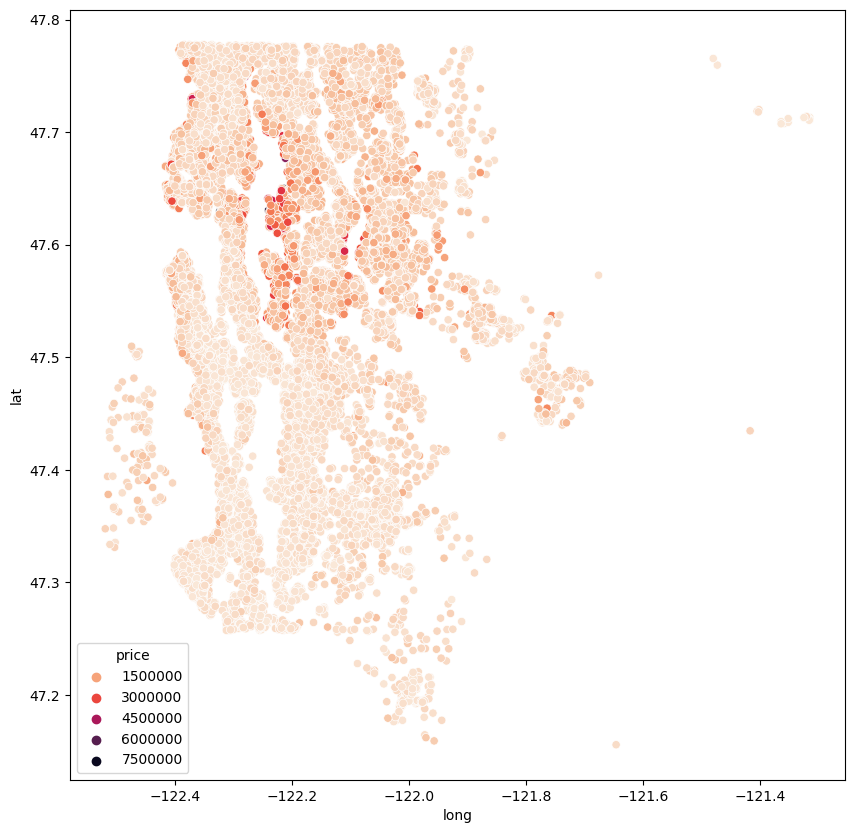

In [10]:
# plotting latitude and longitude as scatter plot to check for location outliers

plt.figure(figsize=(10,10))
sns.scatterplot(data=houses, x="long", y="lat", hue="price", palette="rocket_r");

Location affect the price - the closer to the center, the higher is the price. Also, we wan't to remove outliers - locations far away from the area we are focusing on.

In [11]:
# drop the properties located far east 
houses.drop(houses[houses['long'] > -121.7].index, inplace=True)

In [12]:
# Analyzing range of values (minimum, maximum) and their relationships to the interquartile range (IQR)
houses.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,house_id,id.1
count,2.079500e+04,20795.000000,20795.000000,20795.000000,2.079500e+04,20795.000000,18503.000000,20733.000000,20795.000000,20795.000000,...,20795.000000,17087.000000,20795.000000,20795.000000,20795.000000,20795.000000,20795.000000,2.079500e+04,2.079500e+04,20795.000000
mean,4.577433e+09,3.382688,2.119464,2093.060063,1.539929e+04,1.487016,0.007783,0.238460,3.414090,7.666170,...,1970.860207,848.043542,98077.661649,47.559270,-122.213880,1995.632219,12972.324790,5.436722e+05,4.577433e+09,10826.455109
std,2.875762e+09,0.926161,0.770559,922.022896,4.208954e+04,0.533367,0.087877,0.772659,0.651323,1.177858,...,29.225107,4026.070845,53.606545,0.138938,0.138583,687.471418,27659.658436,3.698955e+05,2.875762e+09,6211.122129
min,1.000102e+06,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,...,1900.000000,0.000000,98001.000000,47.159300,-122.519000,399.000000,659.000000,7.800000e+04,1.000102e+06,1.000000
25%,2.123044e+09,3.000000,1.750000,1440.000000,5.102000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,1951.000000,0.000000,98033.000000,47.468750,-122.327000,1490.000000,5158.000000,3.241800e+05,2.123044e+09,5464.500000
50%,3.904960e+09,3.000000,2.250000,1930.000000,7.680000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,...,1975.000000,0.000000,98065.000000,47.571000,-122.229000,1850.000000,7669.000000,4.520000e+05,3.904960e+09,10859.000000
75%,7.305600e+09,4.000000,2.500000,2560.000000,1.080000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,1996.000000,0.000000,98117.000000,47.677600,-122.124000,2378.000000,10128.000000,6.500000e+05,7.305600e+09,16197.500000
max,9.900000e+09,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,...,2015.000000,20150.000000,98199.000000,47.777600,-121.701000,6210.000000,871200.000000,7.700000e+06,9.900000e+09,21597.000000


Potential outliers exist in bedrooms, bathrooms, sqft_living, sqft_lot, price - the difference between the last interquartile and max value is significant. These we wan't to keep for now, for the further analysis and vizualizations.

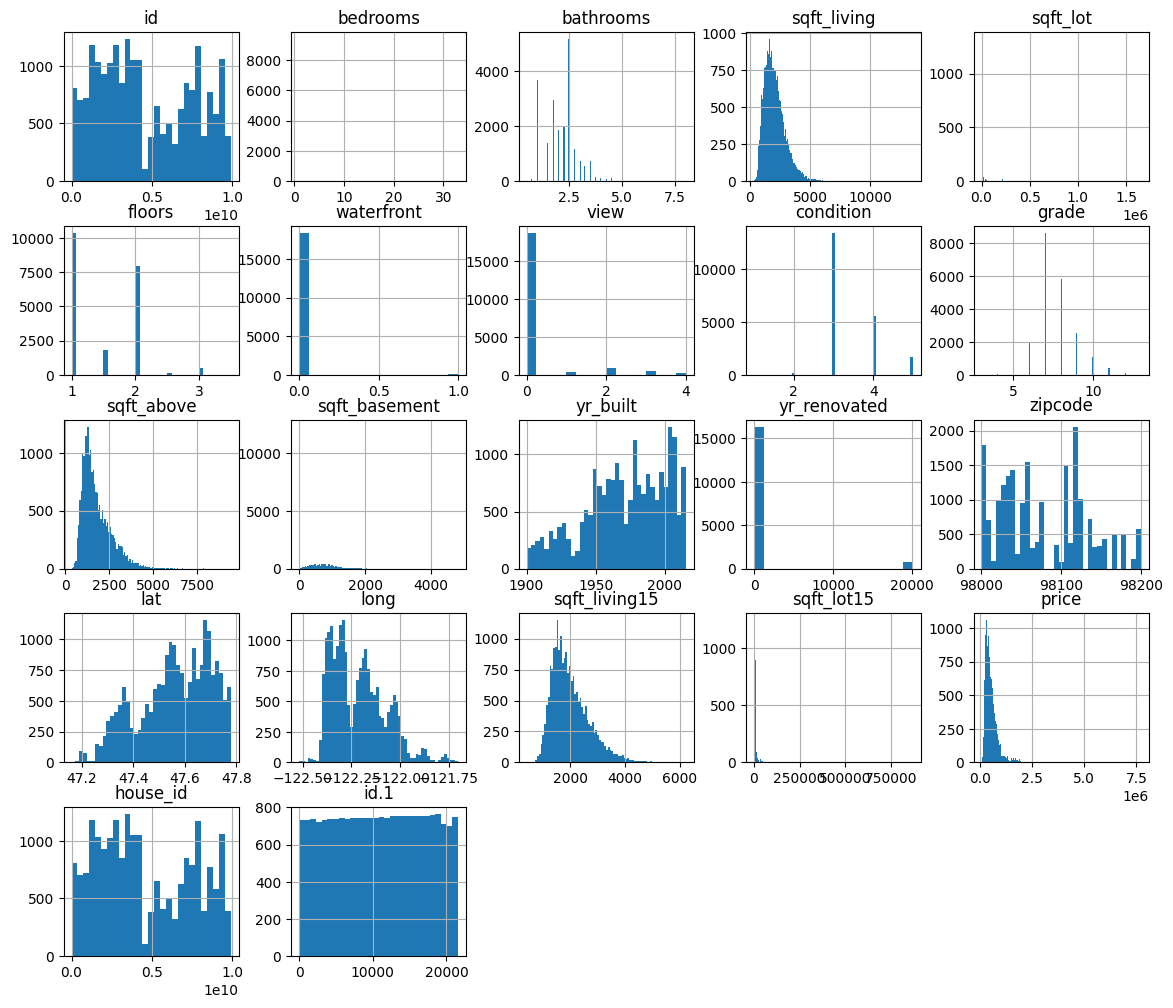

In [13]:
houses.hist(figsize=(14,12), bins='auto');

#### Remove unnecessary columns

In [14]:
houses.drop('id', axis=1, inplace=True)

#### Change the data type for 'view' rating column

In [15]:
houses.view.unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

In [16]:
houses.view = houses.view.astype('Int64')

#### Change the data type for date

In [17]:
houses["date"]=pd.to_datetime(houses["date"])

#### Change the data type for the renovation year

In [18]:
houses.yr_renovated = houses.yr_renovated.apply(lambda x: x/10)
houses.yr_renovated = houses.yr_renovated.replace('NaN', np.nan)
houses['yr_renovated'] = houses['yr_renovated'].fillna(0).astype(int)

#### Add the column with the clasification to Modern, 'Mid-century', 'Late-modern' and Historical houses

In [19]:
def categorize_age(year):
    if 1900 <= year <= 1940:
        return 'Historical'
    elif 1941 <= year <= 1970:
        return 'Mid-century'
    elif 1971 <= year <= 2004:
        return 'Late-modern'
    elif 2005 <= year <= 2015:
        return 'Modern'

# Apply function to create a new column 'age_range'
houses['age_category'] = houses['yr_built'].apply(categorize_age)
houses

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,house_id,id.1,age_category
0,3.0,1.00,1180.0,5650.0,1.0,NaN,0,3,7,1180.0,...,98178,47.5112,-122.257,1340.0,5650.0,2014-10-13,221900.0,7129300520,1,Mid-century
1,3.0,2.25,2570.0,7242.0,2.0,0.0,0,3,7,2170.0,...,98125,47.7210,-122.319,1690.0,7639.0,2014-12-09,538000.0,6414100192,2,Mid-century
2,2.0,1.00,770.0,10000.0,1.0,0.0,0,3,6,770.0,...,98028,47.7379,-122.233,2720.0,8062.0,2015-02-25,180000.0,5631500400,3,Historical
3,4.0,3.00,1960.0,5000.0,1.0,0.0,0,5,7,1050.0,...,98136,47.5208,-122.393,1360.0,5000.0,2014-12-09,604000.0,2487200875,4,Mid-century
4,3.0,2.00,1680.0,8080.0,1.0,0.0,0,3,8,1680.0,...,98074,47.6168,-122.045,1800.0,7503.0,2015-02-18,510000.0,1954400510,5,Late-modern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3.0,2.50,1530.0,1131.0,3.0,0.0,0,3,8,1530.0,...,98103,47.6993,-122.346,1530.0,1509.0,2014-05-21,360000.0,263000018,21593,Modern
21593,4.0,2.50,2310.0,5813.0,2.0,0.0,0,3,8,2310.0,...,98146,47.5107,-122.362,1830.0,7200.0,2015-02-23,400000.0,6600060120,21594,Modern
21594,2.0,0.75,1020.0,1350.0,2.0,0.0,0,3,7,1020.0,...,98144,47.5944,-122.299,1020.0,2007.0,2014-06-23,402101.0,1523300141,21595,Modern
21595,3.0,2.50,1600.0,2388.0,2.0,NaN,0,3,8,1600.0,...,98027,47.5345,-122.069,1410.0,1287.0,2015-01-16,400000.0,291310100,21596,Late-modern


#### Rename the columns

In [20]:
new_cols_names={'sqft_lot':'parcel_sqft', 'sqft_living':'living_sqft', "view":"view_quality", "grade":"KC_grade",
                "yr_built":"built_year", "yr_renovated":"renovation_year", "lat":"latitude", "long":"longitude",
                }

houses.rename(new_cols_names, axis=1, inplace=True)

In [21]:
houses.built_year.value_counts().sort_values()

built_year
1934     21
1935     23
1902     27
1901     28
1933     29
       ... 
1977    410
2004    415
2005    420
2006    429
2014    501
Name: count, Length: 116, dtype: int64

In [22]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20795 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   bedrooms         20795 non-null  float64       
 1   bathrooms        20795 non-null  float64       
 2   living_sqft      20795 non-null  float64       
 3   parcel_sqft      20795 non-null  float64       
 4   floors           20795 non-null  float64       
 5   waterfront       18503 non-null  float64       
 6   view_quality     20733 non-null  Int64         
 7   condition        20795 non-null  int64         
 8   KC_grade         20795 non-null  int64         
 9   sqft_above       20795 non-null  float64       
 10  sqft_basement    20355 non-null  float64       
 11  built_year       20795 non-null  int64         
 12  renovation_year  20795 non-null  int32         
 13  zipcode          20795 non-null  int64         
 14  latitude         20795 non-null  float64   

# Hypothesis 1

In [23]:
houses

,bedrooms,bathrooms,living_sqft,parcel_sqft,floors,waterfront,view_quality,condition,KC_grade,sqft_above,...,zipcode,latitude,longitude,sqft_living15,sqft_lot15,date,price,house_id,id.1,age_category
0,3.0,1.00,1180.0,5650.0,1.0,NaN,0,3,7,1180.0,...,98178,47.5112,-122.257,1340.0,5650.0,2014-10-13,221900.0,7129300520,1,Mid-century
1,3.0,2.25,2570.0,7242.0,2.0,0.0,0,3,7,2170.0,...,98125,47.7210,-122.319,1690.0,7639.0,2014-12-09,538000.0,6414100192,2,Mid-century
2,2.0,1.00,770.0,10000.0,1.0,0.0,0,3,6,770.0,...,98028,47.7379,-122.233,2720.0,8062.0,2015-02-25,180000.0,5631500400,3,Historical
3,4.0,3.00,1960.0,5000.0,1.0,0.0,0,5,7,1050.0,...,98136,47.5208,-122.393,1360.0,5000.0,2014-12-09,604000.0,2487200875,4,Mid-century
4,3.0,2.00,1680.0,8080.0,1.0,0.0,0,3,8,1680.0,...,98074,47.6168,-122.045,1800.0,7503.0,2015-02-18,510000.0,1954400510,5,Late-modern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3.0,2.50,1530.0,1131.0,3.0,0.0,0,3,8,1530.0,...,98103,47.6993,-122.346,1530.0,1509.0,2014-05-21,360000.0,263000018,21593,Modern
21593,4.0,2.50,2310.0,5813.0,2.0,0.0,0,3,8,2310.0,...,98146,47.5107,-122.362,1830.0,7200.0,2015-02-23,400000.0,6600060120,21594,Modern
21594,2.0,0.75,1020.0,1350.0,2.0,0.0,0,3,7,1020.0,...,98144,47.5944,-122.299,1020.0,2007.0,2014-06-23,402101.0,1523300141,21595,Modern
21595,3.0,2.50,1600.0,2388.0,2.0,NaN,0,3,8,1600.0,...,98027,47.5345,-122.069,1410.0,1287.0,2015-01-16,400000.0,291310100,21596,Late-modern


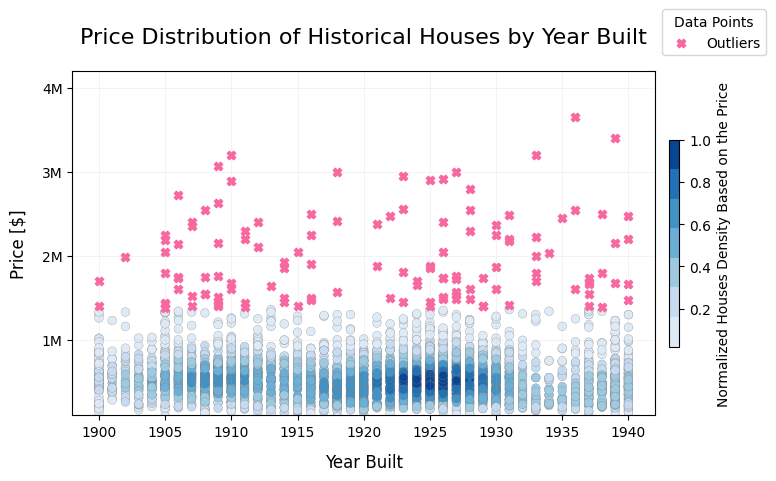

In [ ]:
# Assuming you have the DataFrame 'houses' defined with 'age_category', 'built_year', and 'price'
houses_hist = houses[houses['age_category'].isin(['Historical'])]
Q1 = houses_hist['price'].quantile(0.25)
Q3 = houses_hist['price'].quantile(0.75)
IQR = Q3 - Q1

# Define upper threshold for the price of modern houses 
upper_threshold = Q3 + (2 * IQR)

# Filter outliers - set up the threshold:
hist_houses_filtered = houses_hist[houses_hist['price'] < upper_threshold]

# Calculate density using Gaussian KDE
kde = gaussian_kde([hist_houses_filtered['built_year'], hist_houses_filtered['price']])

# For density estimation, we only need the values for the filtered data
density_values = kde(np.vstack([hist_houses_filtered['built_year'], hist_houses_filtered['price']]))

# Normalize density values for visualization
density_normalized = density_values / np.max(density_values)

blue_colors = ['#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#084594'] 

cmap = ListedColormap(blue_colors)

# Create a scatter plot with normalized density coloring
plt.figure(figsize=(8, 5))
scatter = plt.scatter(hist_houses_filtered['built_year'], hist_houses_filtered['price'], 
                      c=density_normalized, 
                      cmap=cmap, s=40, edgecolor='gray', linewidth=0.2)  # Adjusted point size

# Adding outliers
houses_outliers = houses_hist[houses_hist['price'] > upper_threshold]
plt.scatter(houses_outliers['built_year'], houses_outliers['price'], color='darkorange', marker='X', label='Outliers')


# Y-axis formatting to display in millions (M)
def millions_formatter(x, pos):
    return f'{int(x * 1e-6)}M'

# Set intervals every 1 M
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1e6))

# Apply the formatter to the y axis using FuncFormatter (millions formatter is passed to FuncFormatter)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# Plot settings
plt.title("Price Distribution of Historical Houses by Year Built", fontsize=16, pad=20)
plt.xlabel("Year Built", fontsize=12, labelpad=10)
plt.ylabel("Price [$]", fontsize=12, labelpad=10)
plt.ylim(100000, 4200000) # I set up the limit to skip the largest outlier

cbar = plt.colorbar(scatter, label='Normalized Houses Density Based on the Price', shrink=0.6, pad=0.02)  # Density bar
cbar.ax.tick_params(labelsize=10)

# Display the legend and locate it outside
plt.legend(title="Data Points", loc='upper left', bbox_to_anchor=(1, 1.2)) 

plt.tight_layout()  # Adjust layout
plt.grid(alpha=0.2, linewidth=0.5)
plt.show()

#plt.savefig("Price Distribution of Historical Houses by Year Built.jpg", format='jpg', dpi=300)


########### In this plot I skip 1 outlier - 1 property with the price over 7M

In [25]:
houses_hist.price.mean()

606289.4800627944

In [26]:
houses_hist.price.median()


530000.0

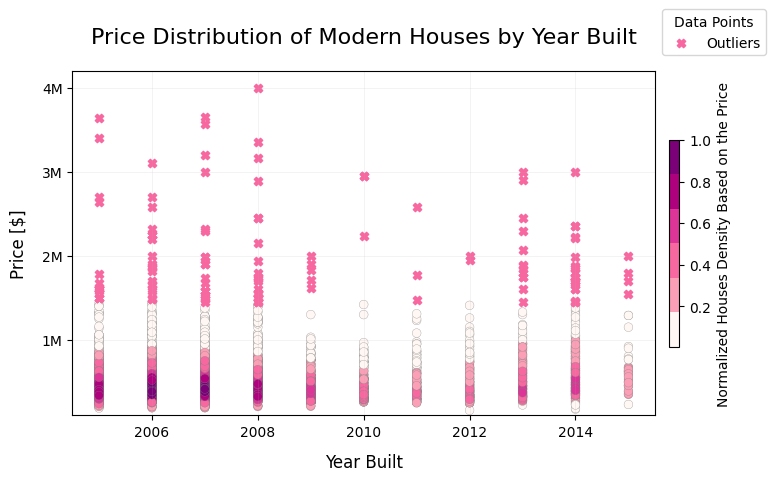

In [ ]:
# Assuming you have the DataFrame 'houses' defined with 'age_category', 'built_year', and 'price'
houses_modern = houses[houses['age_category'].isin(['Modern'])]

# Filter outliers

houses_modern = houses[houses['age_category'].isin(['Modern'])]
Q1 = houses_modern['price'].quantile(0.25)
Q3 = houses_modern['price'].quantile(0.75)
IQR = Q3 - Q1

# Define upper threshold for the price of modern houses 
upper_threshold = Q3 + (2 * IQR)
houses_filtered_modern = houses_modern[houses_modern['price'] < upper_threshold]

# Calculate density using Gaussian KDE

# Load the array
kde = gaussian_kde([houses_filtered_modern['built_year'], houses_filtered_modern['price']])

# For density estimation, we only need the values for the filtered data
density_values = kde(np.vstack([houses_filtered_modern['built_year'], houses_filtered_modern['price']]))

# Normalize density values for visualization
density_normalized = density_values / np.max(density_values)

dark2_colors = ['#fff7f3','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177']  # Extracted colors from Dark2

cmap = ListedColormap(dark2_colors)
# Create a scatter plot with normalized density coloring
plt.figure(figsize=(8, 5))
scatter = plt.scatter(houses_filtered_modern['built_year'], houses_filtered_modern['price'], 
                      c=density_normalized, 
                      cmap=cmap, s=40, edgecolor='gray', linewidth=0.2)  # Adjusted point size

# Adding outliers
houses_outliers = houses_modern[houses_modern['price'] > upper_threshold]
plt.scatter(houses_outliers['built_year'], houses_outliers['price'], color='darkorange', marker='X', label='Outliers')

# Y-axis formatting to display in millions (M)
def millions_formatter(x, pos):
    return f'{int(x * 1e-6)}M'

plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1e6))

# Plot settings
plt.title("Price Distribution of Modern Houses by Year Built", fontsize=16, pad=20)
plt.xlabel("Year Built", fontsize=12, labelpad=10)
plt.ylabel("Price [$]", fontsize=12, labelpad=10)
plt.ylim(100000, 4200000)

plt.grid(alpha=0.3)

cbar = plt.colorbar(scatter, label='Normalized Houses Density Based on the Price', shrink=0.6, pad=0.02)  # Updated color bar
cbar.ax.tick_params(labelsize=10)

plt.grid(alpha=0.2, linewidth=0.5)
plt.legend(title="Data Points",loc='upper left', bbox_to_anchor=(1, 1.2))
plt.tight_layout()  # Adjust layout
plt.savefig("Price Distribution of Modern Houses by Year Built.jpg", format='jpg', dpi=300)
plt.show()

################ In this property I skip 1 outlier - the property with the price over 5M

The 1.5 × IQR rule was extended to 1.6 to keep wider range of houses. When using this rule for analyzing modern house prices, we identify many outliers. While the majority of data points fall within the thresholds defined by this rule (non-outliers), a significant number lie outside these thresholds. These outliers represent high-priced properties, which are important for hypothesis testing as they provide valuable insights into the characteristics of expensive homes. However, for subsequent steps, such as preparing data for modeling and price prediction, only the non-outlier data points should be included to ensure the accuracy and reliability of the models.

In [28]:
houses_modern.price.mean()

625352.5540402319

In [29]:
houses_modern.price.median()

510000.0

# Parcel size analysis

Historical houses analysis

In [30]:
# Filter outliers
houses_hist = houses[houses['age_category'].isin(['Historical'])]
Q1 = houses_hist['parcel_sqft'].quantile(0.25)
Q3 = houses_hist['parcel_sqft'].quantile(0.75)
IQR = Q3 - Q1

# Define upper threshold for the price of modern houses 
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + (2 * IQR)
print(lower_threshold, upper_threshold)

-500.0 13000.0


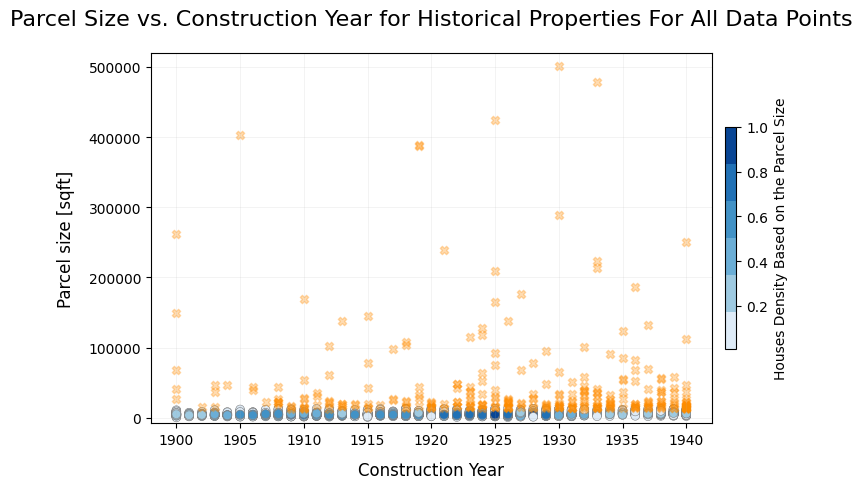

Spearman Correlation: 0.24809917298515147


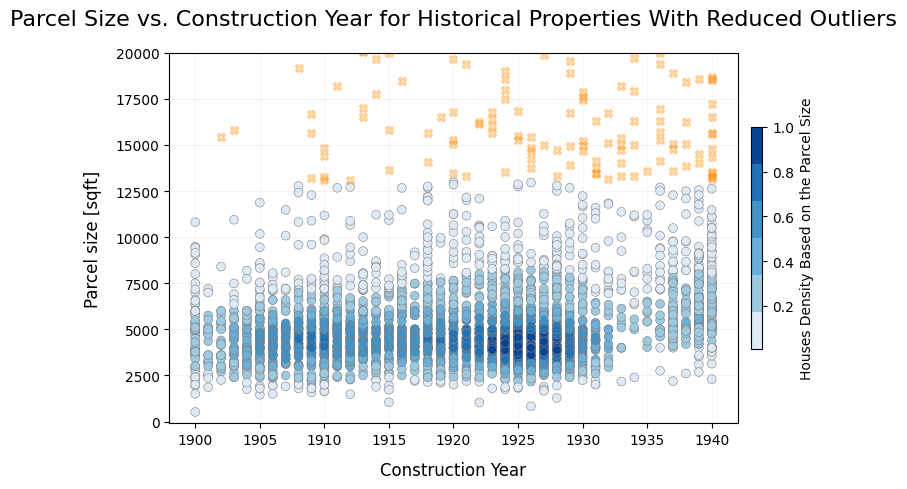

In [31]:
# Filter outliers

houses_outliers = houses_hist[houses_hist['parcel_sqft'] > upper_threshold]
houses_inliers = houses_hist[houses_hist['parcel_sqft'] <= upper_threshold]

# Calculate density using Gaussian KDE
kde = gaussian_kde([houses_inliers['built_year'], houses_inliers['parcel_sqft']])
# For density estimation, we only need the values for the filtered data
density_values = kde(np.vstack([houses_inliers['built_year'], houses_inliers['parcel_sqft']]))

# Normalize density values for visualization
density_normalized = density_values / np.max(density_values)
# Add a blue color scale
blue_colors = ['#deebf7','#9ecae1','#6baed6','#4292c6','#2171b5','#084594']  
cmap = ListedColormap(blue_colors)

# Create a scatter plot with normalized density coloring
plt.figure(figsize=(8, 5))
scatter = plt.scatter(houses_inliers['built_year'], houses_inliers['parcel_sqft'], 
                      c=density_normalized, 
                      cmap=cmap, s=40, edgecolor='gray', linewidth=0.4)  # Adjusted point size

# Plot outliers
plt.scatter(houses_outliers['built_year'], houses_outliers['parcel_sqft'], color='darkorange', marker='X', alpha=0.3, label='Outliers')

# Plot settings
plt.title("Parcel Size vs. Construction Year for Historical Properties For All Data Points", fontsize=16, pad=20)
plt.xlabel("Construction Year", fontsize=12, labelpad=10)
plt.ylabel("Parcel size [sqft]", fontsize=12, labelpad=10)
plt.grid(alpha=0.3)
plt.ylim(-8000, 520000)

cbar = plt.colorbar(scatter, label='Houses Density Based on the Parcel Size', shrink=0.6, pad=0.02)  # Updated color bar
cbar.ax.tick_params(labelsize=10)
plt.grid(alpha=0.2, linewidth=0.5)
plt.tight_layout()  # Adjust layout
plt.savefig("Parcel Size vs. Construction Year for Historical Properties (Over 15,000 sqft).jpg", format='jpg', dpi=300)
plt.show()

# Spearman correlation
spearman_corr = houses_hist['built_year'].corr(houses_hist['parcel_sqft'], method='spearman')
print(f"Spearman Correlation: {spearman_corr}")

############################### The same plot, but showing the distribution of inliers, reducing the scale: ##################################################

# Filter outliers

houses_outliers = houses_hist[houses_hist['parcel_sqft'] > upper_threshold]
houses_inliers = houses_hist[houses_hist['parcel_sqft'] <= upper_threshold]

# Calculate density using Gaussian KDE
kde = gaussian_kde([houses_inliers['built_year'], houses_inliers['parcel_sqft']])
# For density estimation, we only need the values for the filtered data
density_values = kde(np.vstack([houses_inliers['built_year'], houses_inliers['parcel_sqft']]))

# Normalize density values for visualization
density_normalized = density_values / np.max(density_values)
# Add a blue color scale
blue_colors = ['#deebf7','#9ecae1','#6baed6','#4292c6','#2171b5','#084594']  
cmap = ListedColormap(blue_colors)

# Create a scatter plot with normalized density coloring
plt.figure(figsize=(8, 5))
scatter = plt.scatter(houses_inliers['built_year'], houses_inliers['parcel_sqft'], 
                      c=density_normalized, 
                      cmap=cmap, s=40, edgecolor='gray', linewidth=0.4)  # Adjusted point size

# Plot outliers
plt.scatter(houses_outliers['built_year'], houses_outliers['parcel_sqft'], color='darkorange', marker='X', alpha=0.3, label='Outliers')

# Plot settings
plt.title("Parcel Size vs. Construction Year for Historical Properties With Reduced Outliers", fontsize=16, pad=20)
plt.xlabel("Construction Year", fontsize=12, labelpad=10)
plt.ylabel("Parcel size [sqft]", fontsize=12, labelpad=10)
plt.grid(alpha=0.3)
plt.ylim(-100, 20000)

cbar = plt.colorbar(scatter, label='Houses Density Based on the Parcel Size', shrink=0.6, pad=0.02)  # Updated color bar
cbar.ax.tick_params(labelsize=10)
plt.grid(alpha=0.2, linewidth=0.5)
plt.tight_layout()  # Adjust layout
plt.savefig("Parcel Size vs. Construction Year for Historical Properties (Over 15,000 sqft).jpg", format='jpg', dpi=300)
plt.show()


Modern Houses Analysis

-5497.5 16764.0


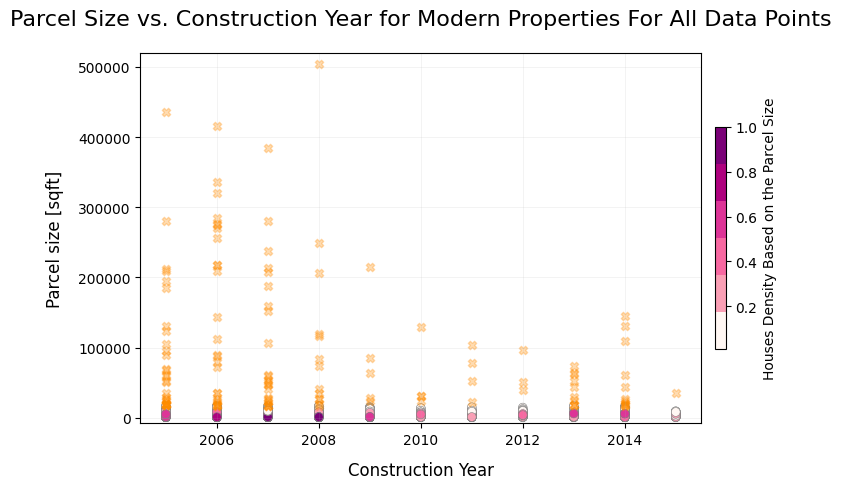

-5497.5 16764.0


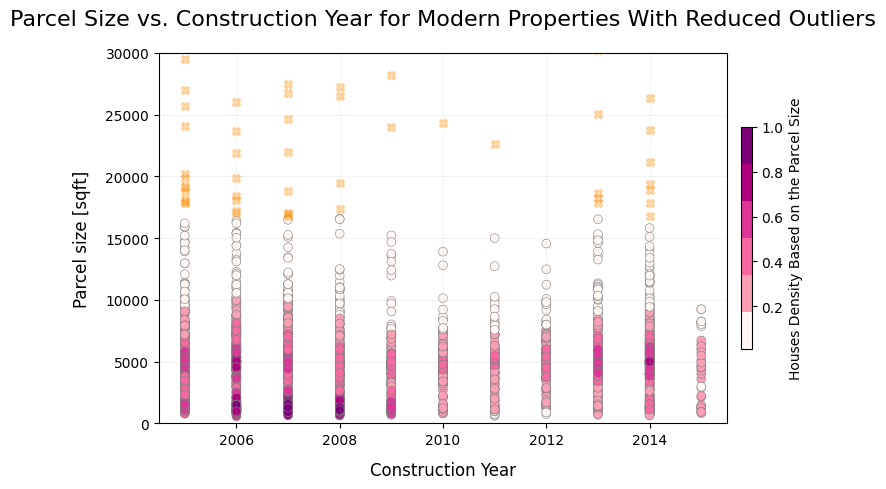

In [32]:
# Filter outliers
houses_modern = houses[houses['age_category'].isin(['Modern'])]
Q1_modern = houses_modern['parcel_sqft'].quantile(0.25)
Q3_modern = houses_modern['parcel_sqft'].quantile(0.75)
IQR_modern = Q3_modern - Q1_modern

# Define upper threshold for the price of modern houses 
lower_threshold_modern = Q1_modern - 1.5 * IQR_modern
upper_threshold_modern = Q3_modern + (2 * IQR_modern)
print(lower_threshold_modern, upper_threshold_modern)
# Filter outliers

houses_outliers_modern = houses_modern[houses_modern['parcel_sqft'] > upper_threshold_modern]
houses_inliers_modern = houses_modern[houses_modern['parcel_sqft'] <= upper_threshold_modern]

# Calculate density using Gaussian KDE
kde = gaussian_kde([houses_inliers_modern['built_year'], houses_inliers_modern['parcel_sqft']])
# For density estimation, we only need the values for the filtered data
density_values_modern = kde(np.vstack([houses_inliers_modern['built_year'], houses_inliers_modern['parcel_sqft']]))

# Normalize density values for visualization
density_normalized_modern = density_values_modern / np.max(density_values_modern)
# Add a blue color scale
pink_scale = ['#fff7f3','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177']  # Extracted colors from Dark2
pink_scale = ListedColormap(pink_scale)

# Create a scatter plot with normalized density coloring
plt.figure(figsize=(8, 5))
scatter = plt.scatter(houses_inliers_modern['built_year'], houses_inliers_modern['parcel_sqft'], 
                      c=density_normalized_modern, 
                      cmap=pink_scale, s=40, edgecolor='gray', linewidth=0.4)  # Adjusted point size

# Plot outliers
plt.scatter(houses_outliers_modern['built_year'], houses_outliers_modern['parcel_sqft'], color='darkorange', marker='X', alpha=0.3, label='Outliers')

# Plot settings
plt.title("Parcel Size vs. Construction Year for Modern Properties For All Data Points", fontsize=16, pad=20)
plt.xlabel("Construction Year", fontsize=12, labelpad=10)
plt.ylabel("Parcel size [sqft]", fontsize=12, labelpad=10)
plt.grid(alpha=0.3)
plt.ylim(-8000, 520000)

cbar = plt.colorbar(scatter, label='Houses Density Based on the Parcel Size', shrink=0.6, pad=0.02)  # Updated color bar
cbar.ax.tick_params(labelsize=10)
plt.grid(alpha=0.2, linewidth=0.5)
plt.tight_layout()  # Adjust layout
plt.savefig("Parcel Size vs. Construction Year for Modern Properties (Over 15,000 sqft).jpg", format='jpg', dpi=300)
plt.show()

# Spearman correlation
spearman_corr = houses_modern['built_year'].corr(houses_modern['parcel_sqft'], method='spearman')

################################################ Filter out outliers #####################################################

# Filter outliers
houses_modern = houses[houses['age_category'].isin(['Modern'])]
Q1_modern = houses_modern['parcel_sqft'].quantile(0.25)
Q3_modern = houses_modern['parcel_sqft'].quantile(0.75)
IQR_modern = Q3_modern - Q1_modern

# Define upper threshold for the price of modern houses 
lower_threshold_modern = Q1_modern - 1.5 * IQR_modern
upper_threshold_modern = Q3_modern + (2 * IQR_modern)
print(lower_threshold_modern, upper_threshold_modern)
# Filter outliers

houses_outliers_modern = houses_modern[houses_modern['parcel_sqft'] > upper_threshold_modern]
houses_inliers_modern = houses_modern[houses_modern['parcel_sqft'] <= upper_threshold_modern]

# Calculate density using Gaussian KDE
kde = gaussian_kde([houses_inliers_modern['built_year'], houses_inliers_modern['parcel_sqft']])
# For density estimation, we only need the values for the filtered data
density_values_modern = kde(np.vstack([houses_inliers_modern['built_year'], houses_inliers_modern['parcel_sqft']]))

# Normalize density values for visualization
density_normalized_modern = density_values_modern / np.max(density_values_modern)
# Add a blue color scale
pink_scale = ['#fff7f3','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177']  # Extracted colors from Dark2
pink_scale = ListedColormap(pink_scale)

# Create a scatter plot with normalized density coloring
plt.figure(figsize=(8, 5))
scatter = plt.scatter(houses_inliers_modern['built_year'], houses_inliers_modern['parcel_sqft'], 
                      c=density_normalized_modern, 
                      cmap=pink_scale, s=40, edgecolor='gray', linewidth=0.4)  # Adjusted point size

# Plot outliers
plt.scatter(houses_outliers_modern['built_year'], houses_outliers_modern['parcel_sqft'], color='darkorange', marker='X', alpha=0.3, label='Outliers')

# Plot settings
plt.title("Parcel Size vs. Construction Year for Modern Properties With Reduced Outliers", fontsize=16, pad=20)
plt.xlabel("Construction Year", fontsize=12, labelpad=10)
plt.ylabel("Parcel size [sqft]", fontsize=12, labelpad=10)
plt.grid(alpha=0.3)
plt.ylim(0, 30000)

cbar = plt.colorbar(scatter, label='Houses Density Based on the Parcel Size', shrink=0.6, pad=0.02)  # Updated color bar
cbar.ax.tick_params(labelsize=10)
plt.grid(alpha=0.2, linewidth=0.5)
plt.tight_layout()  # Adjust layout
plt.savefig("Parcel Size vs. Construction Year for Modern Properties (Over 15,000 sqft).jpg", format='jpg', dpi=300)
plt.show()

# Parcel VS Price

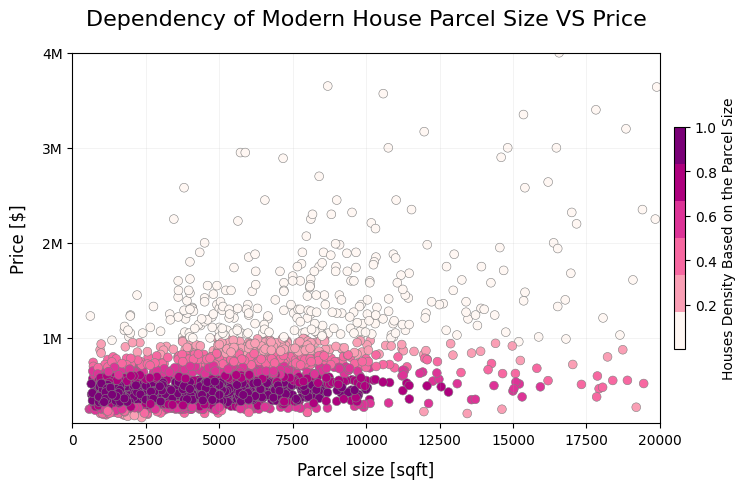

In [34]:
# Assuming you have the DataFrame 'houses' defined with 'age_category', 'built_year', and 'price'
houses_modern = houses[houses['age_category'].isin(['Modern'])]


# Calculate density using Gaussian KDE
kde = gaussian_kde([houses_modern['parcel_sqft'], houses_modern['price']])
# For density estimation, we only need the values for the filtered data
density_values = kde(np.vstack([houses_modern['parcel_sqft'], houses_modern['price']]))

# Normalize density values for visualization
density_normalized = density_values / np.max(density_values)

dark2_colors = ['#fff7f3','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177']
cmap = ListedColormap(dark2_colors)

# Create a scatter plot with normalized density coloring
plt.figure(figsize=(8, 5))
scatter = plt.scatter(houses_modern['parcel_sqft'], houses_modern['price'], 
                      c=density_normalized, 
                      cmap=cmap, s=40, edgecolor='gray', linewidth=0.4)  # Adjusted point size



# Y-axis formatting to display in millions (M)
def millions_formatter(x, pos):
    return f'{int(x * 1e-6)}M'

plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(1e6))

# Plot settings
plt.title("Dependency of Modern House Parcel Size VS Price", fontsize=16, pad=20)
plt.xlabel("Parcel size [sqft]", fontsize=12, labelpad=10)
plt.ylabel("Price [$]", fontsize=12, labelpad=10)
plt.grid(alpha=0.2)
plt.xlim(0, 20000)
plt.ylim(100000, 4000000)

cbar = plt.colorbar(scatter, label='Houses Density Based on the Parcel Size', shrink=0.6, pad=0.02)  # Updated color bar
cbar.ax.tick_params(labelsize=10)

plt.grid(alpha=0.2, linewidth=0.5)
plt.tight_layout()  # Adjust layout
plt.show()

In [35]:
# Spearman correlation
spearman_corr = houses_modern['price'].corr(houses_modern['parcel_sqft'], method='spearman')
print(f"Spearman Correlation: {spearman_corr}")

Spearman Correlation: 0.45153428319367045


# Hypothesis 2 


In [36]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20795 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   bedrooms         20795 non-null  float64       
 1   bathrooms        20795 non-null  float64       
 2   living_sqft      20795 non-null  float64       
 3   parcel_sqft      20795 non-null  float64       
 4   floors           20795 non-null  float64       
 5   waterfront       18503 non-null  float64       
 6   view_quality     20733 non-null  Int64         
 7   condition        20795 non-null  int64         
 8   KC_grade         20795 non-null  int64         
 9   sqft_above       20795 non-null  float64       
 10  sqft_basement    20355 non-null  float64       
 11  built_year       20795 non-null  int64         
 12  renovation_year  20795 non-null  int32         
 13  zipcode          20795 non-null  int64         
 14  latitude         20795 non-null  float64   

### Which houses based on age category contain more than 4 bathrooms

In [37]:
four_bath = houses[houses['bathrooms'] > 4].groupby('age_category').bathrooms.count()
four_bath

age_category
Historical      25
Late-modern    131
Mid-century     24
Modern          81
Name: bathrooms, dtype: int64

Mostly late-modern and modern houses have 4+ bathrooms

In [38]:
house_cat = houses.groupby('age_category').bathrooms.count()


In [39]:
Hist = four_bath/house_cat *100
Hist

age_category
Historical     0.784929
Late-modern    1.629759
Mid-century    0.361500
Modern         2.761677
Name: bathrooms, dtype: float64

### Show the quality of view for each age category

In [40]:
houses.groupby('age_category').view_quality.value_counts()

age_category  view_quality
Historical    0               2758
              2                204
              3                101
              4                 60
              1                 53
Late-modern   0               7290
              2                332
              3                186
              4                121
              1                 83
Mid-century   0               5887
              2                312
              1                155
              3                152
              4                112
Modern        0               2726
              2                 92
              3                 59
              1                 31
              4                 19
Name: count, dtype: int64

In [41]:
houses[houses['bathrooms']>4].KC_grade.value_counts()

KC_grade
11    82
10    71
12    31
9     27
8     25
7     16
13     9
Name: count, dtype: int64

In [42]:
houses[houses['bathrooms']>4].view_quality.value_counts()

view_quality
0    151
2     35
3     32
4     31
1      9
Name: count, dtype: Int64

In [43]:
houses[houses['bathrooms']>4].condition.value_counts()

condition
3    209
4     38
5     14
Name: count, dtype: int64

In [44]:
houses[houses['bathrooms']>4].waterfront.value_counts()

waterfront
0.0    220
1.0     17
Name: count, dtype: int64

In [45]:
bath=houses[houses['bathrooms']>4]
bath[bath['KC_grade']>9].groupby('age_category').view_quality.value_counts()

age_category  view_quality
Historical    2                6
              0                4
              4                2
              1                1
              3                1
Late-modern   0               52
              4               18
              2               15
              3               14
              1                2
Mid-century   0                2
              2                2
              3                2
              4                2
Modern        0               43
              2                9
              3                7
              4                5
              1                3
Name: count, dtype: int64

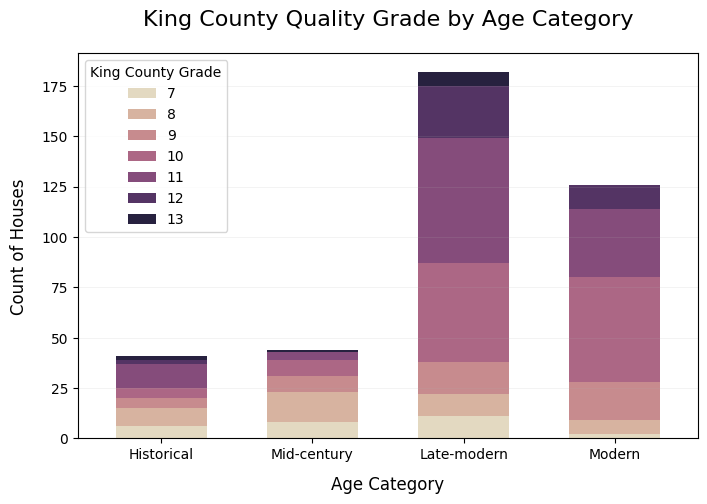

In [46]:
light_pink =sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
# Group data by age category, view quality, and KC grade
luxury_counts = houses[houses['bathrooms'] >= 4].groupby(['age_category', 'KC_grade']).size().unstack(fill_value=0)

# Redefine the order of age categories
category_order = ["Historical", "Mid-century", "Late-modern", "Modern"]
luxury_counts = luxury_counts.reindex(category_order)

# Stacked bar plot
luxury_counts.plot(kind='bar', width=0.6, stacked=True, colormap=light_pink, figsize=(8, 5))
plt.title("King County Quality Grade by Age Category", fontsize=16, pad=20)

#plt.subplots_adjust(left=0.3, right=0.95, bottom=0.2, top=0.9)

plt.xlabel("Age Category", fontsize=12 ,labelpad=10)
plt.xticks(rotation=0, fontsize=10)
plt.ylabel("Count of Houses", fontsize=12 ,labelpad=10)
plt.legend(title="King County Grade")
plt.grid(axis='y', alpha=0.2, linewidth=0.5)

#plt.savefig("KC_Quality Grade by Age Category for Houses with 4+ Bathrooms.jpg", format='jpg', dpi=300)
plt.show()

# Condition of houses with 4+ bathrooms, depending on age category


In [47]:
houses.condition.unique()

array([3, 5, 4, 1, 2], dtype=int64)

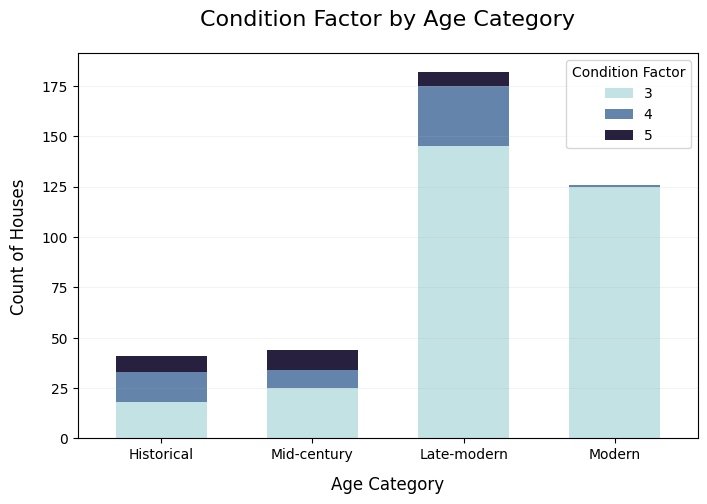

In [48]:
dark2_colors = ['#fee391', '#fe9929', '#fc4e2a'] 
cmap2 = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

# Group data by age category, view quality, and KC grade
condition_counts = houses[houses['bathrooms'] >= 4].groupby(['age_category', 'condition']).size().unstack(fill_value=0)

# Redefine the order of age categories
category_order = ["Historical", "Mid-century", "Late-modern", "Modern"]
condition_counts = condition_counts.reindex(category_order)

# Stacked bar plot
condition_counts.plot(kind='bar', width=0.6, stacked=True, colormap=cmap2, figsize=(8, 5))
plt.title("Condition Factor by Age Category", fontsize=16, pad=20)
plt.xlabel("Age Category", fontsize=12 ,labelpad=10)
plt.xticks(rotation=0, fontsize=10)

plt.ylabel("Count of Houses", fontsize=12 ,labelpad=10)
plt.legend(title="Condition Factor")
plt.grid(axis='y', alpha=0.2, linewidth=0.5)

#plt.savefig("Condition by Age Category for Houses with 4+ Bathrooms.jpg", format='jpg', dpi=300)
plt.show()

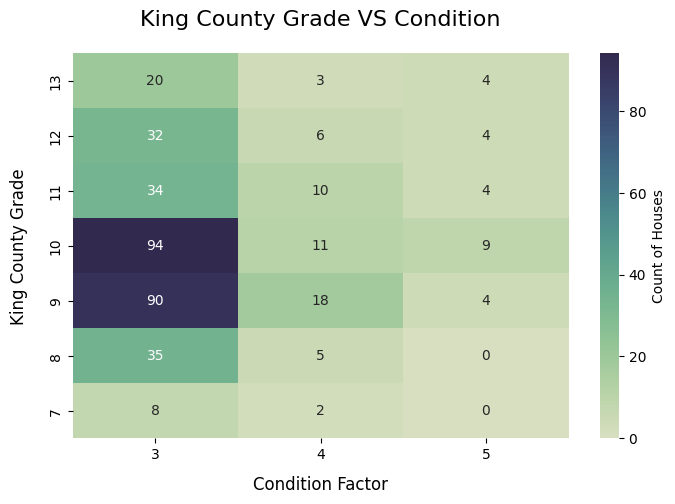

In [49]:
# Create pivot table for heatmap
heatmap_data = houses[houses['bathrooms'] >= 4].groupby(['KC_grade', 'condition']).size().unstack(fill_value=0)

# Plot heatmap : annot: if true write the values inside the cell; fmt - string formatting code,
# center(says to what value the colormap should be centered, cbar_kws its a dict for value mapping, 
# optionally cbar boolean wheather to draw a colorbar)

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(
    heatmap_data,
    annot=True,          # Annotate cells with their values
    fmt="d",             # Format of the annotation text
    cmap=cmap,           # Use the cubehelix colormap
    center=50,           # Center the colormap (adjust based on data)
    cbar_kws={'label': 'Count of Houses'},
    yticklabels=heatmap_data.index[::-1]
)

# Title and axis labels
plt.title("King County Grade VS Condition", fontsize=16, pad=20)
plt.xlabel("Condition Factor", fontsize=12, labelpad=10)
plt.ylabel("King County Grade", fontsize=12, labelpad=15)

#plt.savefig("KC Grade VS Condition.jpg", format='jpg', dpi=300)

# Show the plot
#plt.tight_layout()  # Automatically adjusts subplot parameters to give specified padding
plt.show()

In [50]:
waterfront = houses[houses['bathrooms'] >= 4].waterfront.value_counts()
waterfront

waterfront
0.0    332
1.0     22
Name: count, dtype: int64

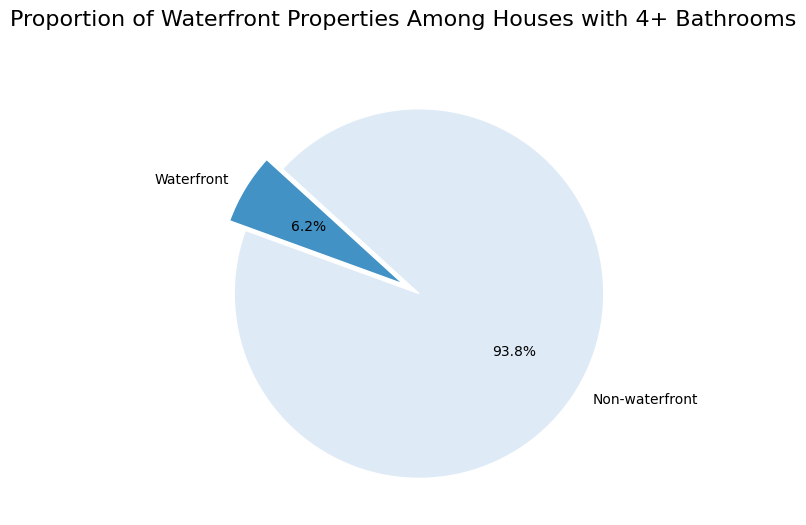

In [51]:
# Plotting a pie chart for the waterfront
dark2_colors = ['#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#084594'] 

plt.figure(figsize=(8, 6))
plt.pie(
    waterfront, 
    labels=['Non-waterfront' if x == 0 else 'Waterfront' for x in waterfront.index ],  # Use the index (e.g., 1 for waterfront, 0 for non-waterfront)
    autopct='%1.1f%%',        # Display percentages of each category
    startangle=160,           # Add an angle for better layout
    colors=['#deebf7', '#4292c6'],  # Colors for waterfront and non-waterfront categories
    wedgeprops={'edgecolor': 'white'},  # Optional: adds a black edge around slices
    explode=(0.1,0),
    
)
plt.title("Proportion of Waterfront Properties Among Houses with 4+ Bathrooms", fontsize=16, pad=20)

#plt.savefig("Waterfromt for 4+ bathroom houses.jpg", format='jpg', dpi=300)
plt.show()

In [52]:
view = houses[houses['bathrooms'] >= 4].view_quality.value_counts()
view



view_quality
0    249
2     49
3     41
4     38
1     13
Name: count, dtype: Int64

In [53]:
type(view.index)

pandas.core.indexes.base.Index

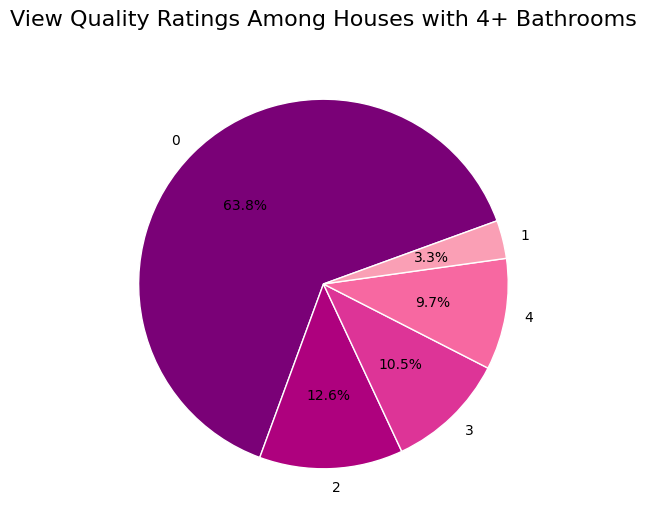

In [54]:
# Plotting a pie chart for the view quality

dark2_colors = reversed(['#fff7f3','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177'])

plt.figure(figsize=(8, 6))
plt.pie(
    view, 
    labels=view.index,
    autopct='%1.1f%%',        # Display percentages of each category
    startangle=20,           # The angle by which the start of the pie is rotated, counterclockwise from the x-axis.
    colors=dark2_colors,  # Colors for waterfront and non-waterfront categories
    wedgeprops={'edgecolor': 'white'}  # Optional: adds a black edge around slices
    
)

plt.title("View Quality Ratings Among Houses with 4+ Bathrooms", fontsize=16, pad=20)

#plt.savefig("View Quality Rating.jpg", format='jpg', dpi=300)
plt.show()


In [55]:
houses.groupby('waterfront')['view_quality'].value_counts()

waterfront  view_quality
0.0         0               16631
            2                 814
            3                 412
            1                 284
            4                 163
1.0         4                 122
            3                  13
            2                   7
            1                   1
Name: count, dtype: int64

# Hypothesis 3

## Calculate the distances to the nearest golf club

Adding the Data Frame with locations of top golf courses in King County:

In [56]:
golf_courses_data = {'name':['Maplewood Golf Course', 'The Golf Club at Newcastle', 'Auburn Golf Course', 'Mount Si Golf Course', 'Interbay Golf Center',
                             "Druid's Glen Golf Club", "Glen Acres Golf & Country Club", 'Sand Point Country Club', 'Foster Golf Links'], 
                     'latitude':['47.4719', '47.5356', '47.3362', '47.5192', '47.6438', '47.3326', '47.5040','47.6888', '47.48132'], 
                     'longitude':['-122.157', '-122.143', '-122.2066', '-121.797', '-122.378', '-122.066', '-122.319', '-122.269', '-122.265'], 
                     'zipcode':['98058', '98059', '98092', '98065', '98119', '98042', '98168','98115','98168']}
golf_courses = pd.DataFrame(golf_courses_data)

The great_circle function imported from the geopy.distance module is specifically designed to calculate distances between two latitude-longitude coordinates on a spherical model of the Earth, and it automatically handles the calculations internally.

In [57]:
# Function to calculate the nearest golf course for each house in the DataFrame
def calculate_nearest_golf_course(houses_df, golf_courses_df):

    # Apply the nearest_golf_course function to each house's latitude and longitude
    houses_df['distance_to_nearest_golf_course'] = houses_df.apply(
        lambda house: nearest_golf_course(house['latitude'], house['longitude'], golf_courses_df),
        axis=1
    )
    return houses_df


# Individual distance calculation function using great_circle

def nearest_golf_course(house_lat, house_lon, golf_courses_df):
    house_location = (house_lat, house_lon)

    # Calculate distances from the house to each golf course - for each golf course apply the great circle function - 
    # take the latitude and longitude of the golf course and calculate the distance from the house locatiion, return 
    # the smallest value

    distances = golf_courses_df.apply(
        lambda x: great_circle(house_location, (x['latitude'], x['longitude'])).miles,
        axis=1
    )
    
    # Return the minimum distance (closest golf course)
    return distances.min()

# Calling the function:
houses_with_distances = calculate_nearest_golf_course(houses, golf_courses)

houses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20795 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   bedrooms                         20795 non-null  float64       
 1   bathrooms                        20795 non-null  float64       
 2   living_sqft                      20795 non-null  float64       
 3   parcel_sqft                      20795 non-null  float64       
 4   floors                           20795 non-null  float64       
 5   waterfront                       18503 non-null  float64       
 6   view_quality                     20733 non-null  Int64         
 7   condition                        20795 non-null  int64         
 8   KC_grade                         20795 non-null  int64         
 9   sqft_above                       20795 non-null  float64       
 10  sqft_basement                    20355 non-null  float64       

Analysis of 'distances to the closest golf course' based on the Waterfront and Non_Waterfront Locations

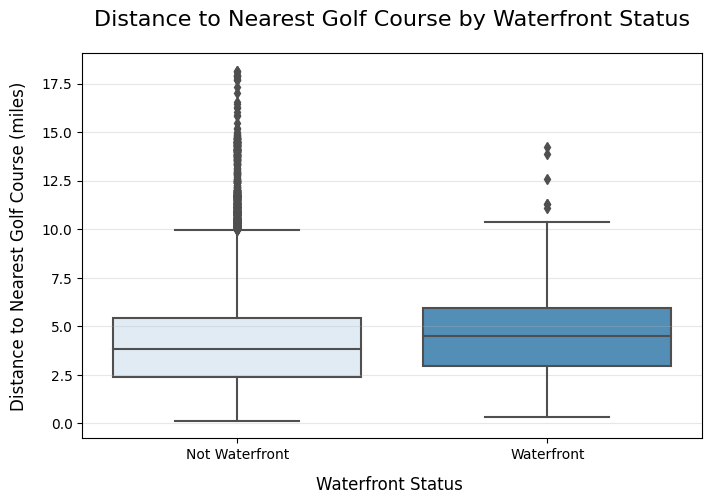

In [58]:
# Set up the figure
plt.figure(figsize=(8, 5))

# Create a box plot or violin plot showing distance to nearest golf course by waterfront status
sns.boxplot(
    data=houses,
    x='waterfront',
    y='distance_to_nearest_golf_course',
    palette=['#deebf7', '#4292c6']  # Color scheme for non-waterfront and waterfront
)

# Customize plot aesthetics
plt.title("Distance to Nearest Golf Course by Waterfront Status", fontsize=16, pad=20)
plt.xlabel("Waterfront Status ", fontsize=12, labelpad=10)
plt.ylabel("Distance to Nearest Golf Course (miles)", fontsize=12, labelpad=10)
plt.xticks([0, 1], ["Not Waterfront", "Waterfront"], fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Show the plot
plt.show()

Creating the Box Plot for the analysis of the distance to the closest golf course based on the King County grade

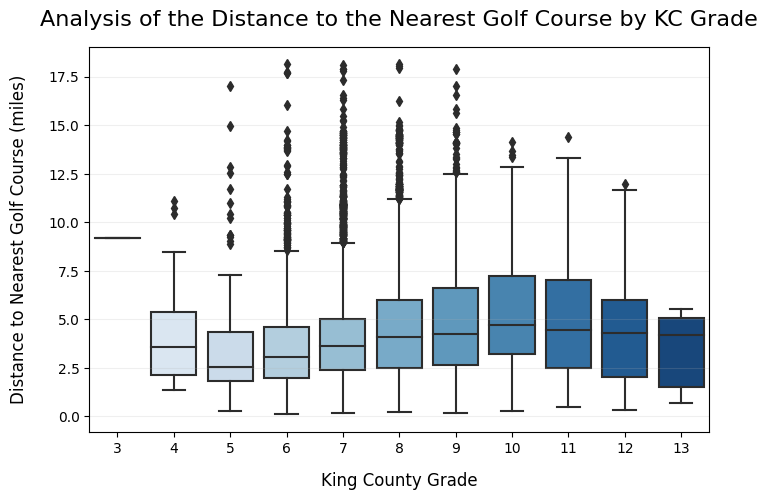

In [59]:
# Assuming 'houses' is your dataframe with 'KC_grade' and 'distance_to_golf' columns
plt.figure(figsize=(8, 5))

# Box Plot
sns.boxplot(data=houses, x='KC_grade', y='distance_to_nearest_golf_course', palette='Blues')
plt.title("Analysis of the Distance to the Nearest Golf Course by KC Grade", fontsize=16, pad=15)
plt.xlabel("King County Grade", fontsize=12, labelpad=12)
plt.ylabel("Distance to Nearest Golf Course (miles)", fontsize=12, labelpad=15)
plt.grid(axis='y', alpha=0.2)
#plt.savefig("Distance to Golf Course VS KC Grade.jpg", format='jpg', dpi=300)
plt.show()

In [60]:
# Spearman correlation
spearman_corr_KC_distance = houses['KC_grade'].corr(houses['distance_to_nearest_golf_course'], method='spearman')
print(f"Spearman Correlation: {spearman_corr}")

Spearman Correlation: 0.45153428319367045


C:\Users\Marcelina\AppData\Local\Temp\ipykernel_21532\2005126223.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=houses, x='KC_grade', y='view_quality', palette='Blues', capsize=0.1, ci="sd")


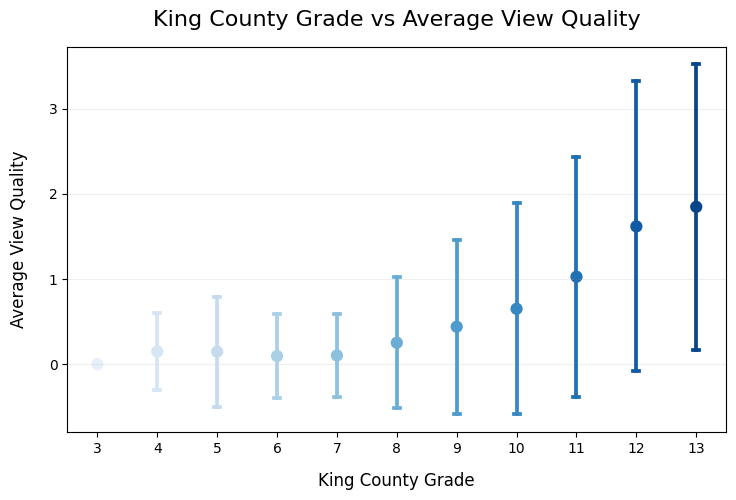

In [61]:
plt.figure(figsize=(8.5, 5))
sns.pointplot(data=houses, x='KC_grade', y='view_quality', palette='Blues', capsize=0.1, ci="sd")
plt.title("King County Grade vs Average View Quality", fontsize=16, pad=15)
plt.xlabel("King County Grade", fontsize=12, labelpad=12)
plt.ylabel("Average View Quality", fontsize=12, labelpad=15)
plt.grid(axis='y', alpha=0.2)
#plt.savefig("View Quality VS KC Grade.jpg", format='jpg', dpi=300)
plt.show()

In [62]:
houses_KC_high_grade = houses[houses['KC_grade'].between(10,13)]


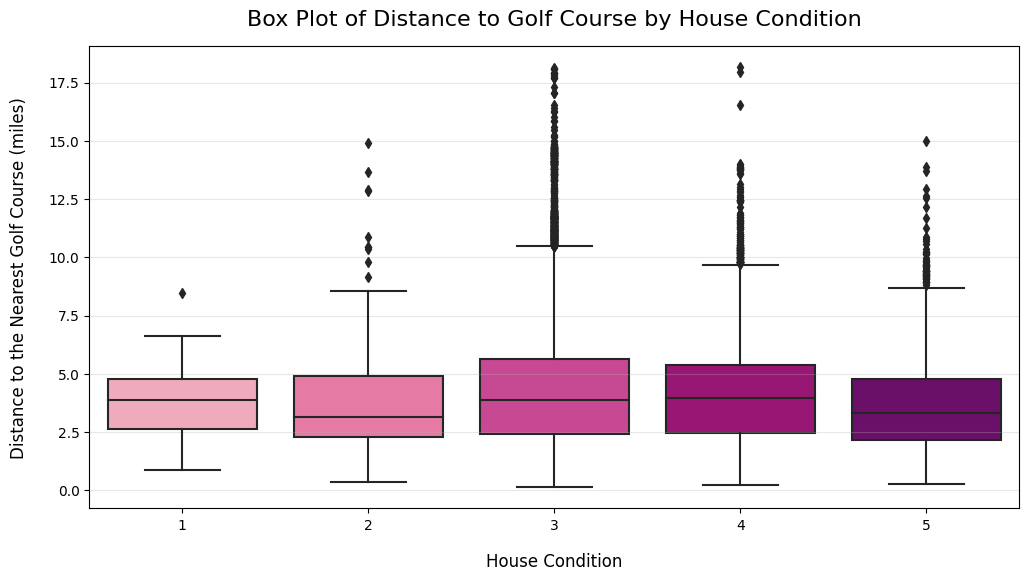

In [63]:

# Assuming 'houses' is your dataframe with 'KC_grade' and 'distance_to_golf' columns
plt.figure(figsize=(12, 6))

# Box Plot

pink_colors = ['#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177']  # Extracted colors from Dark2

sns.boxplot(data=houses, x='condition', y='distance_to_nearest_golf_course', palette=pink_colors)
plt.title("Box Plot of Distance to Golf Course by House Condition", pad=15, fontsize=16)
plt.xlabel("House Condition", fontsize=12, labelpad=15)
plt.ylabel("Distance to the Nearest Golf Course (miles)", fontsize=12, labelpad=15)
plt.grid(axis='y', alpha=0.3)


C:\Users\Marcelina\AppData\Local\Temp\ipykernel_21532\1762223380.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=houses, x='KC_grade', y='condition', palette='Blues', capsize=0.1, ci="sd")


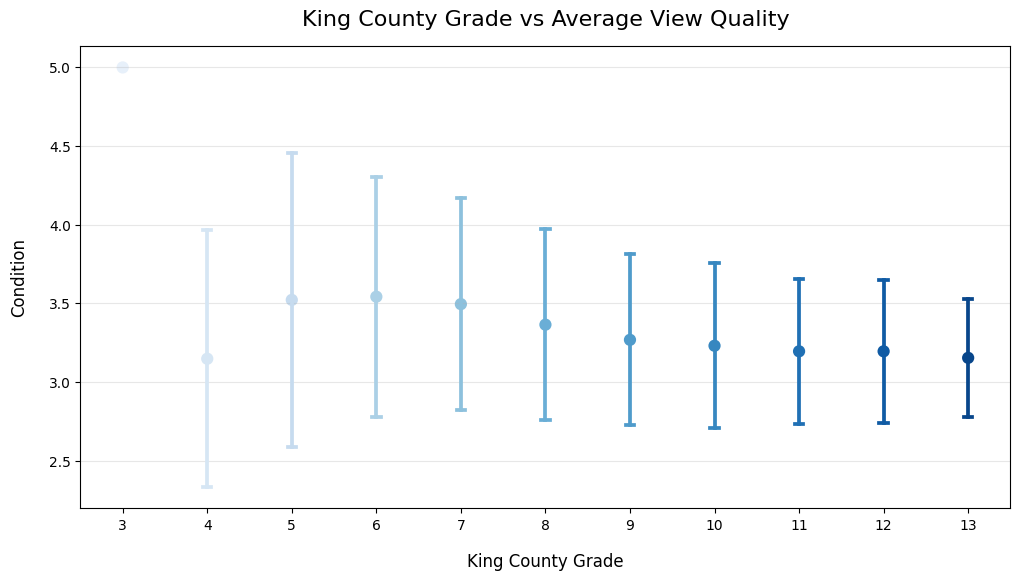

In [64]:
plt.figure(figsize=(12, 6))
sns.pointplot(data=houses, x='KC_grade', y='condition', palette='Blues', capsize=0.1, ci="sd")
plt.title("King County Grade vs Average View Quality", fontsize=16, pad=15)
plt.xlabel("King County Grade", fontsize=12, labelpad=15)
plt.ylabel("Condition", fontsize=12, labelpad=15)
plt.grid(axis='y', alpha=0.3)
plt.show()

## Filter historical houses (built after 1940) with more than 4 bathrooms & no waterfront, with parcel size at least 15000 sqft, subtracting living area



The average tennis court is around 8000 sqft, and the medium size swimming pool is 800 sqft. 

Ideally, to allow flexibility in design and space for other structures, a parcel closer to 15,000 
square feet or larger is recommended.

In [65]:
golf_courses_data = {'name':['Maplewood Golf Course', 'The Golf Club at Newcastle', 'Auburn Golf Course', 'Mount Si Golf Course', 'Interbay Golf Center',
                             "Druid's Glen Golf Club", "Glen Acres Golf & Country Club", 'Sand Point Country Club', 'Foster Golf Links'], 
                     'latitude':['47.4719', '47.5356', '47.3362', '47.5192', '47.6438', '47.3326', '47.5040','47.6888', '47.48132'], 
                     'longitude':['-122.157', '-122.143', '-122.2066', '-121.797', '-122.378', '-122.066', '-122.319', '-122.269', '-122.265'], 
                     'zipcode':['98058', '98059', '98092', '98065', '98119', '98042', '98168','98115','98168']}
golf_courses = pd.DataFrame(golf_courses_data)

# Location of houses with high KC grade and view over 3 

In [66]:
houses_KC_high_grade = houses[(houses['KC_grade'].between(11,13)) & (houses['view_quality']>3)]

In [67]:
houses_KC_high_grade = houses[(houses['KC_grade'].between(11,13)) & (houses['view_quality']>3)]
houses_KC_high_grade

# calculate the avg latitude and longitude of the filtered houses, which is used as the center point for the map.

map_center = [houses_KC_high_grade['latitude'].mean(), houses_KC_high_grade['longitude'].mean()]

# Create a Folium map, with the map centered at the map_center and an initial zoom level of 12.
KC_map = folium.Map(location=map_center, zoom_start=12)

# golf_courses.iterrows() iterates through each row of the golf_courses,

# folium.Marker() adds markers to the map for each golf course's location.
# location is set to the latitude and longitude of the golf course.
# popup shows the name of the golf course when the marker is clicked.
# icon sets the marker color to red.
# .add_to(KC_map) adds these markers to the map.

for index, row in golf_courses.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(color='red')
    ).add_to(KC_map)


# This line creates a list called heat_data, containing pairs of latitudes and longitudes for the houses in 
# houses_KC_high_grade. This list will be used as input for the heatmap.
# It iterates over each row of the houses_KC_high_grade DataFrame and extracts the latitude and longitude.

heat_data = [[row['latitude'], row['longitude']] for index, row in houses_KC_high_grade.iterrows()]


# Generate a color gradient using Seaborn's 'flare' palette (goes from 0 to 255)
flare_palette = sns.color_palette("magma", as_cmap=False, n_colors=256)
flare_gradient = {i/255: f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}' for i, (r, g, b) in enumerate(flare_palette)}

# Add heatmap with 'flare' color gradient to the map
HeatMap(heat_data, gradient=flare_gradient).add_to(KC_map)


# Save the map to an HTML file
KC_map.save('KC_and_golf_courses_map_with_density_only.html')


# Final plot - show on the map location of target houses - meeting all concotions

In [72]:
# Historical houses (built after 1940), more than 4 bathrooms, no waterfront, parcel over 15 ooo sqft:
historical_houses = houses[houses['age_category'] == 'Historical']

hist_bath_water=historical_houses[(houses['bathrooms'] > 4) & (houses['waterfront'].isin([0]))]

meet_all_conditions = hist_bath_water[hist_bath_water['parcel_sqft']> 15000]

C:\Users\Marcelina\AppData\Local\Temp\ipykernel_21532\1784438859.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hist_bath_water=historical_houses[(houses['bathrooms'] > 4) & (houses['waterfront'].isin([0]))]


In [73]:
# Create a Folium map centered on the average location of houses
map_center = [meet_all_conditions['latitude'].mean(), meet_all_conditions['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add historical houses to the map
for index, row in meet_all_conditions.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"House: Zip Code {row['zipcode']}",
        icon=folium.Icon(color='blue')
    ).add_to(m)

# Add golf courses to the map
for index, row in golf_courses.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name'],
        icon=folium.Icon(color='green')
    ).add_to(m)

# Save the map to an HTML file
m.save('houses_and_golf_courses_map.html')

In [74]:
# Calculate distances to the nearest golf course
def nearest_golf_course(house_lat, house_lon):
    house_location = (house_lat, house_lon)
    distances = golf_courses.apply(
        lambda x: great_circle(house_location, (x['latitude'], x['longitude'])).miles,
        axis=1)
    return distances.min()